# Restricted Boltzmann Machines

Group 2314:
- Gloria Isotton   ID: 2072705
- Sara Munafò      ID: 2072380
- Maryam Feizi     ID: 2091504
- Carlo Divari     ID: 1186975

In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
plt.rcParams['font.size'] = 14
from numba import jit, prange

In [2]:
dname="DATA_b"

fname=dname+'/x_RBM_q0.1.dat'

v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)

N = len(v)
L = len(v[1])

#SPINS = True
SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
print('...')

print(v.shape)

each of N=10000 data has L=20 digits
[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1]
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0]
...
(10000, 20)


## Initialize

In [3]:
M=2
# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
#print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

In [4]:
class Data():  #defined a class to address data
    pass
d = Data()
d.w = w
d.a = a
d.b = b
d.v = v
d.GAP = GAP

## Plotting

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1]


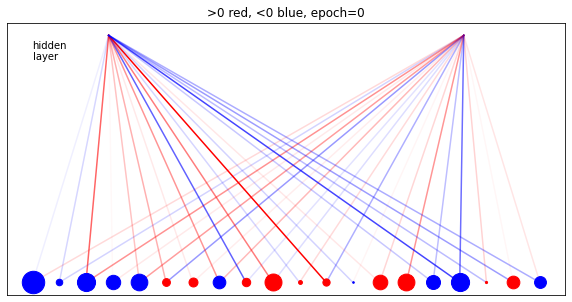

In [5]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./d.w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(d.w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(d.w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(d.a.max()+d.b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(d.a[i]), zorder=2, c=mycolor(d.a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(d.b[j]), zorder=2, c=mycolor(d.b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()

def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(d.w.max(),-d.w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(d.w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(d.w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(d.a[i]), zorder=2, c=mycolor(d.a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(d.b[j])), zorder=2, c=mycolor(d.b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()
                  
plotgraph()

In [6]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out

k = 4
activate(v[k],w,b,GAP,info=True)

input= [0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
act= [-0.26465979  1.34505401]
prob= [0.43421858 0.79331984]
output= [0 0]


array([0, 0])

# 0: PRELIMINARIES

# 0.1: Backward activation function for one-hot encoded structure

If we use the sigmoid as activation function for the backward step of contrastive divergence, for each 4 blocks of the vector there are $2^4$ possible states, while for the way in which our data is structured (one-hot encoding) the ''real'' possible states are only 4: 0001,0010,0100,1000.    

With the new activation function, we take into consideration the energies associated with each possible state, compute the associated probabilities, and generate 4 blocks at a time of the new "fantasy" vector according to in which interval a random number between 0 and 1 is generated. In this way, we preserve the one-hot encoding structure of the original data.

In [7]:
s = np.array([[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])

def activate_back(v,h,w,a,k,steps,info=False):
    
    e = np.zeros(4)
    cprob = np.zeros(4)
    vf = np.zeros(20)
    
    for i in range(0,20,4):
        for j in range(len(s)):
            if np.array_equiv(v[i:i+4],s[j])==True:
                local_f = a[i:i+4]+np.dot(w[i:i+4,:],h)
                e[j]+= np.dot(local_f,v[i:i+4])
     
    bol = np.zeros(4)
    for i in range(len(s)):
        if e[i]!=0:
            bol = exp(-e)
            
    p = bol/bol.sum()

    cprob[0] = p[0]
    for i in range(1,4):
        cprob[i]+=cprob[i-1]+p[i]
        
    for i in range(0,20,4):
        x = np.random.random()
        if x<=cprob[0]:
            vf[i:i+4]=s[0]
        elif x<=cprob[1]:
            vf[i:i+4]=s[1]
        elif x<=cprob[2]:
            vf[i:i+4]=s[2]
        else: 
            vf[i:i+4]=s[3]
            
    #for i in range(0,3):
        #if k == 500*i and steps==1 and info==True:
           # print('----initiating backward CD: k = ',k,'----')
            #print('WEIGHTS[0] : ', w.T[0])
            #print('EVALUATED ENERGIES = ',e, '\n') 
            #print('PROBABILITY : ', p, '\n')                       
            #print('CUMULATIVE PROBABILITY : ', cprob, '\n\n')
            
    return(vf,cprob)



# 0.2: Indicators of performance

In order to have a better idea of how our RBM is performing, we implement the following indicators:
- Energy gap between the states generated by the RBM and the original states
- Second moment
- Log-Likelihood
- Adversarial accuracy

## Energy of RBM

In [8]:
def E(v,h):
    ene = -(np.dot((np.dot(v,w)).T,h))-np.dot(a.T,v)-np.dot(b.T,h)
    return ene

## Log-Likelihood

In [10]:
A = 4
G = 5
def energy(v,h,d):
    eng = - np.dot(d.a,v) - np.dot(d.b,h) - np.dot(v.T@d.w,h)
    return eng

def Z(v,h,d):
    print('un secondo')
    z=0
    for iI,i in enumerate(v):
        for jJ, j in enumerate(h):
             z+=np.exp(-energy(i,j,d))
    return z

def P(v,h,d):
    p=0
    print("Ci siamo quasi")
    for Ii,i in enumerate(v):
        
        h_sum=0
        for jJ,j in enumerate(h):
            h_sum += np.exp(-energy(i,j,d))
        p += np.log(h_sum)
    dist= p/v.shape[0]
    return dist
            
def log_likelihood(v,h,d):
    print('iniziamo')
    L = P(v,h,d) -np.log(Z(v,h,d))
    return L


## Adversarial accuracy indicator

In [11]:
def distance(v1,v2):
    dist=[]
    if np.array_equiv(v1,v2)==True:
        for i in range(v1.shape[0]):
            print('riga:',i)
            dmin = 1e8
            for j in range(v1.shape[0]):
                if j!=i:
                    d = np.linalg.norm(v1[i] - v1[j])
                    if d<dmin:
                        dmin = d
            dist.append(dmin)
            print(dmin)
             
    else:
        for i in range(v1.shape[0]):
            print('riga__:',i)
            dmin = 1e8
            for j in range(v2.shape[0]):
                d = np.linalg.norm(v1[i] - v2[j])
                if d<dmin:
                    dmin = d
            dist.append(dmin)
            print(dmin)
    return(dist)     

def AAI(d1,d2,d3,d4):#DST-DSS-DTS-DTT
    d1 = np.array(d1)
    d2 = np.array(d2)
    d3 = np.array(d3)
    d4 = np.array(d4)
    A12 = d1-d2
    print(A12.shape)
    a12 = A12[A12>0]
    A_fin_12 = len(a12)/N
    print(A_fin_12)
    A34 = d3-d4
    print(A34.shape)
    a34 = A34[A34>0]
    A_fin_34 = len(a34)/N
    print(A_fin_34)
    aai = (A_fin_12-0.5)**2+(A_fin_34-0.5)**2
    return aai

# 0.3: Optimizers

As the vanilla gradient descent didn't work well with our code, we directly implemented two different optimizers:
- ADAM
- RMSprop

### ADAM

In [12]:
class Optimizers():  #defined class for optimizers variables
    pass
opt = Optimizers()
opt.beta1 = 0.9
opt.beta2 = 0.999
opt.beta = 0.9
opt.epsilon=1e-8
opt.m_dw, opt.v_dw = 0, 0 
opt.m_db, opt.v_db = 0, 0
opt.m_da, opt.v_da = 0, 0

In [13]:
def opt_adam(t,opt,d,dw,db,da,l_rate_m):
    ##********update***********#
    opt.m_dw = opt.beta1*opt.m_dw + (1-opt.beta1)*dw
    opt.m_db = opt.beta1*opt.m_db + (1-opt.beta1)*db
    opt.m_da = opt.beta1*opt.m_da + (1-opt.beta1)*da
    ## rms beta 2
    opt.v_dw = opt.beta2*opt.v_dw + (1-opt.beta2)*(dw**2)
    opt.v_db = opt.beta2*opt.v_db + (1-opt.beta2)*(db**2)
    opt.v_da = opt.beta2*opt.v_da + (1-opt.beta2)*(da**2)
    ## bias correction
    m_dw_corr = opt.m_dw/(1-opt.beta1**t)
    m_db_corr = opt.m_db/(1-opt.beta1**t)
    m_da_corr = opt.m_da/(1-opt.beta1**t)
    v_dw_corr = opt.v_dw/(1-opt.beta2**t)
    v_db_corr = opt.v_db/(1-opt.beta2**t)
    v_da_corr = opt.v_da/(1-opt.beta2**t)
     ## update weights and biases
    d.w = d.w - l_rate_m*(m_dw_corr/(np.sqrt(v_dw_corr)+opt.epsilon))
    d.b = d.b - l_rate_m*(m_db_corr/(np.sqrt(v_db_corr)+opt.epsilon))
    d.a = d.a - l_rate_m*(m_da_corr/(np.sqrt(v_da_corr)+opt.epsilon))
    
    return (d.w,d.b,d.a)
                   

### RMSprop

In [14]:
def opt_rms(d,opt,dw,db,da,l_rate_m):
    opt.v_dw = opt.beta*opt.v_dw + (1-opt.beta)*(dw**2)
    opt.v_db = opt.beta*opt.v_db + (1-opt.beta)*(db**2)
    opt.v_da = opt.beta*opt.v_da + (1-opt.beta)*(da**2)
    d.w = d.w - l_rate_m*((dw)/(np.sqrt(opt.v_dw+opt.epsilon)))
    d.b = d.b - l_rate_m*((db)/(np.sqrt(opt.v_db+opt.epsilon)))
    d.a = d.a - l_rate_m*((da)/(np.sqrt(opt.v_da+opt.epsilon)))
    return (d.w,d.b,d.a)

# 0.4: Training function

For the training, our idea is that to try different optimizers and tune parameters such as the learning rate and the mini-batch.
To make this process easier, we implemented a function for training.

In [15]:
np.random.seed(12345)

plotgraph(0)
N = 10000
L = 20
M = 2

In [17]:
def training(n_ad,epochs,cd_steps,l_rate,M,mini,opt,d,N,L,cov_data,SPINS,index_L):
    
    if SPINS:
        # sigmoid takes into account energy difference =2
        d.GAP=2
        # convert 0,1 -> -1,1
        d.v = 2*d.v - 1
        vmin=-1
        s = np.array([[-1,-1,-1,1],[-1,-1,1,-1],[-1,1,-1,-1],[1,-1,-1,-1]])
    else:
        d.GAP=1
        vmin=0
        s = np.array([[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])
    
    t=1
    m = 0
    
    LL=[]
    V =  []
    H =  []
    
    E_rbm = np.zeros(epochs)
    E_d = np.zeros(epochs)
    
    print('===================================================')
    for epoch in range(epochs):
         # aggregate normalization of batch statistics and learning rate
        l_rate_m = l_rate / mini
        
        for k in range(int(N)):
            if m==0:
                # initialize averages in miniblock
                v_data, v_model = np.zeros(L),np.zeros(L)
                h_data, h_model = np.zeros(M),np.zeros(M)
                vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))

            # positive CD phase: generating h 
            h = activate(d.v[k],d.w,d.b,d.GAP)
            hf = h
            vf = d.v[k]
            for i in range(cd_steps):                 #Contrastive Divergence
                vf,_ = activate_back(vf,hf,d.w,d.a,k,i)
                hf = activate(vf,d.w,d.b,d.GAP)
            v_data  += d.v[k]
            v_model += vf
            h_data  += h
            h_model += hf
            vh_data += np.outer(d.v[k].T,h)
            vh_model+= np.outer(vf.T,hf)
        
            V.append(vf)
            H.append(h)
        
            # update energies of the state for each row
            E_rbm[epoch] += E(vf,h)/mini
            E_d[epoch] += E(d.v[k],h)/mini
    
            m += 1
        
            # minibatch
            if m==mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a Adam optimizer
                dw = (vh_data - vh_model)
                da = (v_data - v_model)       
                db = (h_data - h_model)
            
                if epoch<=n_ad: #ADAM
                    d.w,d.b,d.a = opt_adam(t,opt,d,dw,db,da,l_rate_m)
                    
                    m = 0
                    t += 1 #update the time
                   
                else: #RMSprop
                    d.w,d.b,d.a = opt_rms(d,opt,dw,db,da,l_rate_m)

                    m = 0
            
            #if epoch%10==9 and k<=mini:
                #print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                #print('dw =',dw)
                #print('da =',da)
               # print('db =',db)
                #print('vh_data \n', vh_data, '\n')
                #print('vh_model \n',vh_model)
        Vf = np.array(V)     
        Hf = np.array(H)     

        if index_L==True and epoch%10==9:      #LogLikelihood
            LL.append(log_likelihood(Vf,Hf,d))
        V = []
        H = []
        #second moment:
        #second_mom[epoch] = sec_mom(Vf,N,L,cov_data)

        # randomize the order of input data
        np.random.shuffle(d.v)
    
        l_rate = l_rate / (0.01 * l_rate + 1)
        if epoch%10==9:
            plotgraph(epoch+1)
            print('l_rate = ',l_rate)
        
    return(Vf,d.w,d.a,d.b,E_rbm,E_d,LL) 

# 1. DIFFERENCE BETWEEN CD-10 AND CD-100

## 1.2 ADAM CD-100

iniziamo
Ci siamo quasi
un secondo


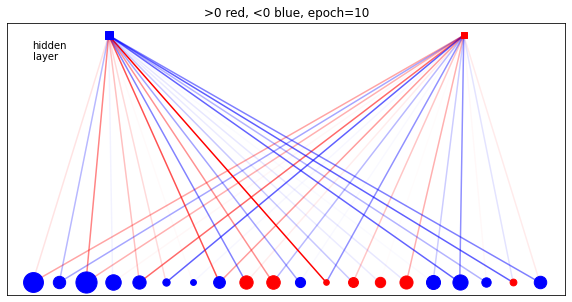

l_rate =  0.9090909090909092
iniziamo
Ci siamo quasi
un secondo


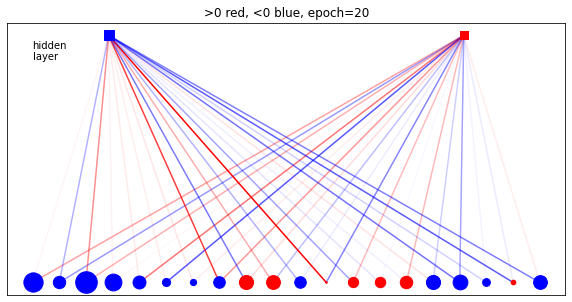

l_rate =  0.8333333333333337
iniziamo
Ci siamo quasi
un secondo


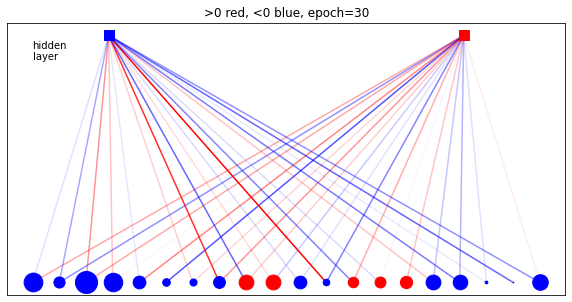

l_rate =  0.7692307692307697
iniziamo
Ci siamo quasi
un secondo


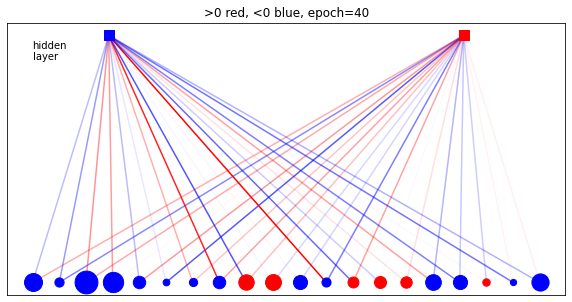

l_rate =  0.7142857142857149
iniziamo
Ci siamo quasi
un secondo


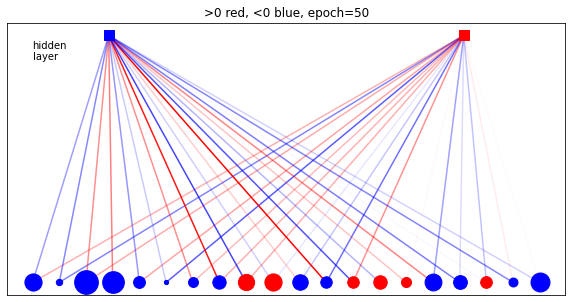

l_rate =  0.6666666666666671
iniziamo
Ci siamo quasi
un secondo


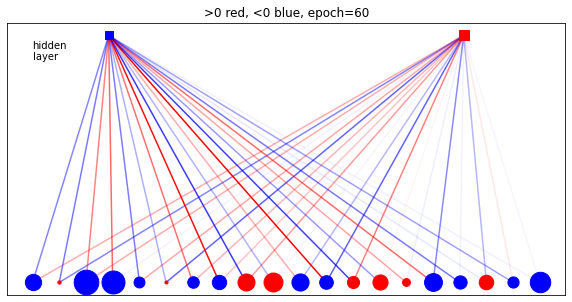

l_rate =  0.6250000000000006
iniziamo
Ci siamo quasi
un secondo


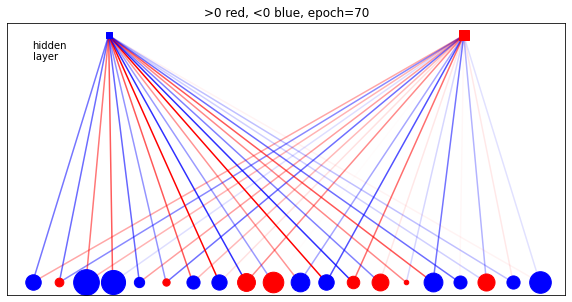

l_rate =  0.5882352941176475
iniziamo
Ci siamo quasi
un secondo


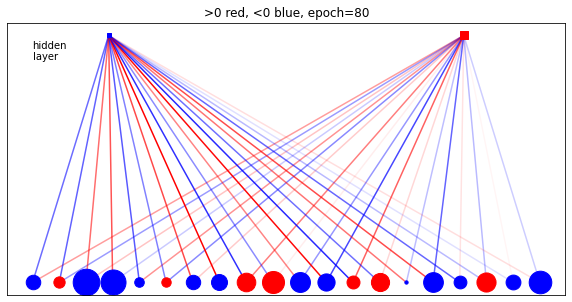

l_rate =  0.555555555555556
iniziamo
Ci siamo quasi
un secondo


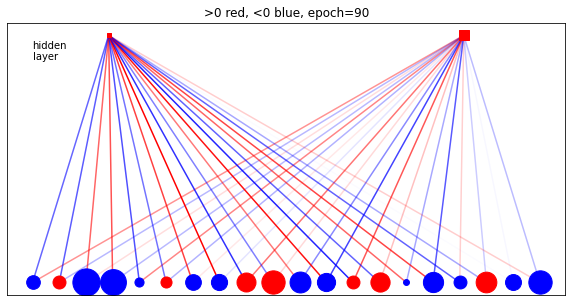

l_rate =  0.5263157894736847
iniziamo
Ci siamo quasi
un secondo


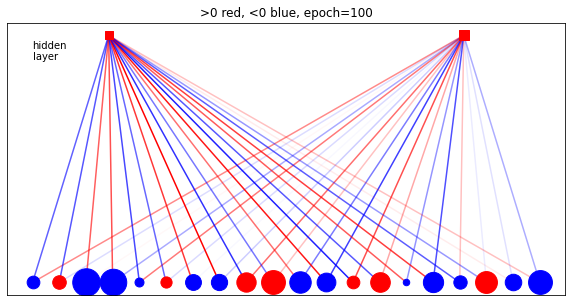

l_rate =  0.5000000000000009
iniziamo
Ci siamo quasi
un secondo


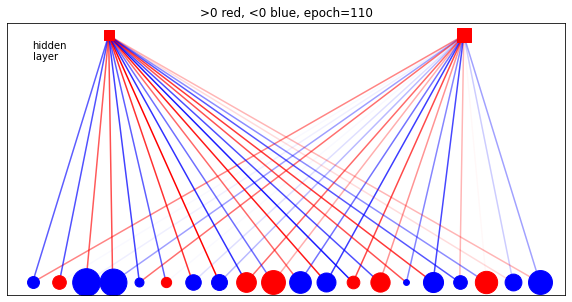

l_rate =  0.47619047619047694
iniziamo
Ci siamo quasi
un secondo


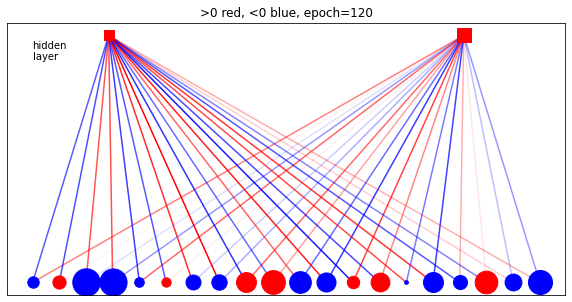

l_rate =  0.4545454545454552
iniziamo
Ci siamo quasi
un secondo


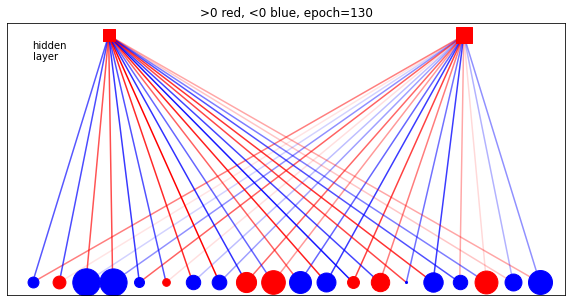

l_rate =  0.43478260869565283
iniziamo
Ci siamo quasi
un secondo


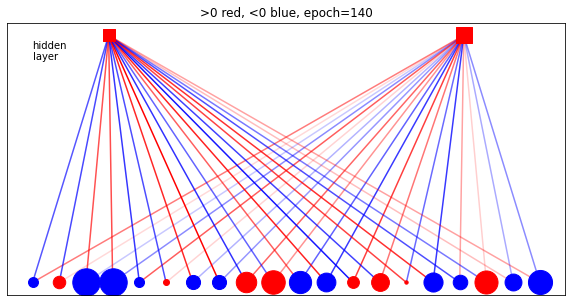

l_rate =  0.41666666666666735
iniziamo
Ci siamo quasi
un secondo


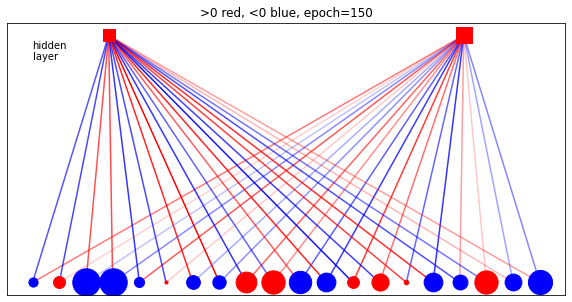

l_rate =  0.40000000000000047
iniziamo
Ci siamo quasi
un secondo


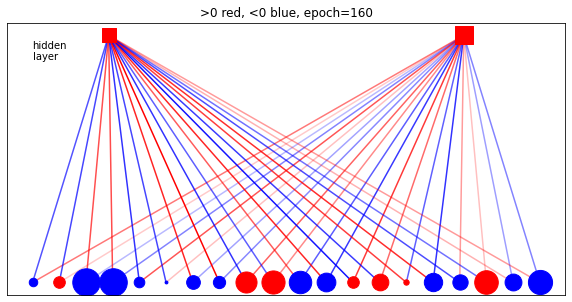

l_rate =  0.3846153846153852
iniziamo
Ci siamo quasi
un secondo


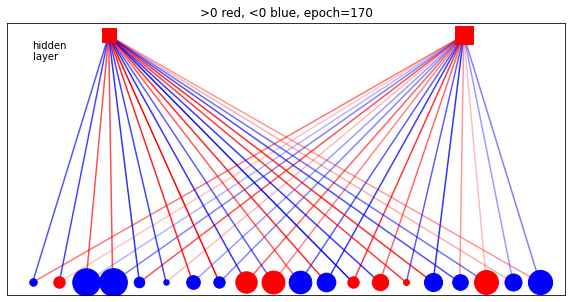

l_rate =  0.370370370370371
iniziamo
Ci siamo quasi
un secondo


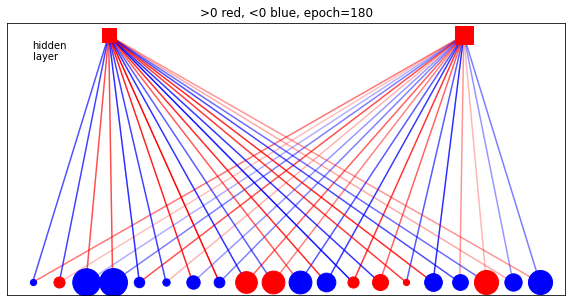

l_rate =  0.35714285714285776
iniziamo
Ci siamo quasi
un secondo


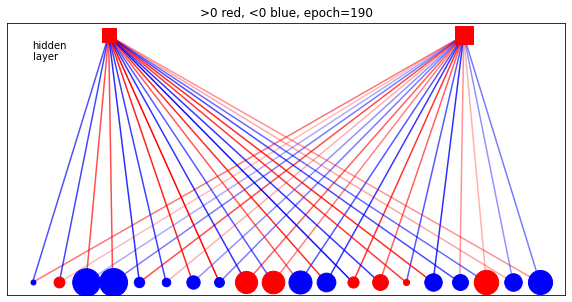

l_rate =  0.344827586206897
iniziamo
Ci siamo quasi
un secondo


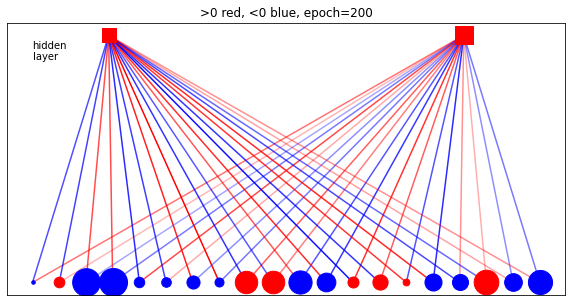

l_rate =  0.33333333333333376


In [18]:
Vf_a,w_a,a_a,b_a,E_rbm_a,E_d_a,Log_a = training(n_ad=200,epochs=200,cd_steps=100,l_rate=1.0,M=2,mini=500,opt=opt,d=d,N=N,L=L,cov_data=cov_data,SPINS=False,index_L=True)

In [19]:
np.savetxt('Vf_500ad_100step.txt',Vf_a)
np.savetxt('E_d_500ad_step.txt',E_d_a)
np.savetxt('E_rbm_500ad_100step.txt',E_rbm_a)
np.savetxt('w_500ad_100step.txt',w_a)
np.savetxt('a_500ad_100step.txt',a_a)
np.savetxt('b_500ad_100step.txt',b_a)
np.savetxt('Log_500ad_100step.txt',Log_a)

In [20]:
Vf_a = np.loadtxt('Vf_500ad_100step.txt')
E_d_a = np.loadtxt('E_d_500ad_step.txt')
E_rbm_a = np.loadtxt('E_rbm_500ad_100step.txt')
Log_a = np.loadtxt('Log_500ad_100step.txt')
epochs = 200

In [56]:
Log_a3 = np.loadtxt('Log_a.txt')

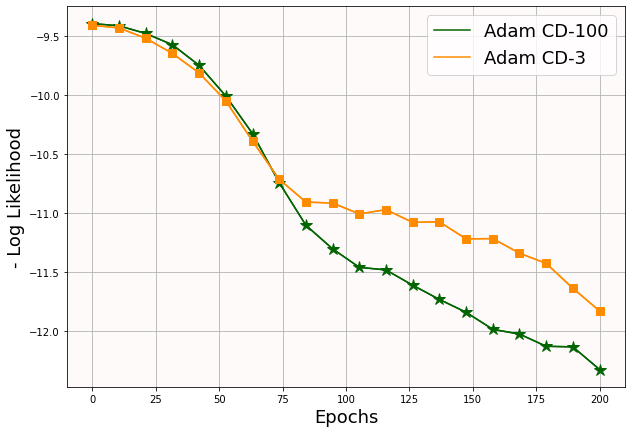

In [63]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(np.linspace(0,epochs,20),Log_a, color='darkgreen',label='Adam CD-100')
ax.plot(np.linspace(0,epochs,20),Log_a,color='darkgreen',marker='*', markersize=12)
ax.plot(np.linspace(0,epochs,20),Log_a3, color='darkorange',label='Adam CD-3')
ax.plot(np.linspace(0,epochs,20),Log_a3,color='darkorange',marker='s', markersize=8)
ax.set_xlabel('Epochs',fontsize=18)
ax.set_ylabel('- Log Likelihood',fontsize=18)
ax.legend(loc='best',fontsize=18)
plt.grid(True)
ax.set_facecolor("snow")
fig.savefig('ottimizzazione_log.png')